<a href="https://colab.research.google.com/github/serafinazhang/Urban-Sound-Classification/blob/main/Code%20book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Urban Sound Classification with Neural Networks**

# 1 Data Preprcessing

## 1.1 Preparation

In [1]:
!pip install librosa
# !pip install specAugment

In [2]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import glob
import os
import tarfile
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from google.colab import files
from zipfile import ZipFile

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
from PIL import Image
import pathlib
import csv
from sklearn import preprocessing
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, Input, Add, TimeDistributed, LSTM, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization, Lambda, GRU, concatenate
from keras import regularizers
from keras.layers.advanced_activations import ELU
from keras import backend
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import adam_v2

In [ ]:
file = tarfile.open("/content/drive/MyDrive/machine learning/UrbanSound8K.tar.gz")
file.extractall('/content/')

In [ ]:
path = '/content/UrbanSound8K/audio/'
def pre_clean(fold):
  path_list = []
  labels = []
  folds = []
  for i in fold:
    this_path = os.path.join(path,i)
    for root, dirs, files_name in os.walk(this_path):
      files_name.remove('.DS_Store')
      for file in files_name:
        path_list.append(os.path.join(root,file))
        label = file.split('-')[1]
        folds.append(i)
        labels.append(label)
  return path_list, labels, folds

In [ ]:
train_path_list, train_labels, train_folds = pre_clean(train_fold)
test_path_list, test_labels, test_folds = pre_clean(test_fold)

In [ ]:
# get raw data from load function
def loading_raw(path_list):
  raw_list = []
  for i in path_list:
    raw, st = librosa.load(i)
    raw_list.append(raw)
  return raw_list

In [ ]:
train_raw = loading_raw(train_path_list)
test_raw = loading_raw(test_path_list)

In [ ]:
np.array(train_raw,dtype=object).dump(open('/content/drive/MyDrive/machine learning/raw data/train_raw.npy', 'wb'))
np.array(test_raw,dtype=object).dump(open('/content/drive/MyDrive/machine learning/raw data/test_raw.npy', 'wb'))

In [ ]:
train_label = pd.DataFrame({'fold': train_folds, 'label': train_labels, 'path_list': train_path_list})
test_label = pd.DataFrame({'fold': test_folds, 'label': test_labels, 'path_list': test_path_list})

In [ ]:
train_label.to_csv('/content/drive/MyDrive/machine learning/raw data/train_label.csv')
test_label.to_csv('/content/drive/MyDrive/machine learning/raw data/test_label.csv')

## 1.2 Data Loading

###1.2.1 Loading Raw

In [ ]:
train_fold = ['fold1', 'fold2', 'fold3', 'fold4', 'fold6']
test_fold = ['fold5', 'fold7', 'fold8', 'fold9', 'fold10']

In [ ]:
train_raw = np.load('/content/drive/MyDrive/machine learning/raw data/train_raw.npy', allow_pickle=True) # sample rate is 22050Hz
test_raw = np.load('/content/drive/MyDrive/machine learning/raw data/test_raw.npy', allow_pickle=True)

In [ ]:
train_meta = pd.read_csv('/content/drive/MyDrive/machine learning/raw data/train_label.csv')
test_meta = pd.read_csv('/content/drive/MyDrive/machine learning/raw data/test_label.csv')

In [ ]:
def extract_name(x):
  l = x.split('/')
  name = l[-1]
  name = name.split('.')[0]
  return name

In [ ]:
train_meta['name'] = train_meta['path_list'].apply(extract_name)
test_meta['name'] = test_meta['path_list'].apply(extract_name)

In [ ]:
valid_raw = test_raw[:936]
test_raw = test_raw[936:]

In [ ]:
valid_meta = test_meta[:936]

In [ ]:
test_meta = test_meta[936:].reset_index()

###1.2.2 Slicing Raw

In [ ]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

In [ ]:
def re_split(raw_data, meta_data, frames = 41):
  column_names = ['name', 'fold', "label"]
  df = pd.DataFrame(columns=column_names)
  array_list = []

  window_size = 512 * (frames - 1)
  for i in range(len(raw_data)):
    sound_clip = raw_data[i]

    for (start,end) in windows(sound_clip,window_size):
      if(len(sound_clip[int(start):int(end)]) == int(window_size)):
        signal = sound_clip[int(start):int(end)]
        array_list.append(signal)
        df = df.append({'name': meta_data['name'][i], 'fold': meta_data['fold'][i], 'label': meta_data['label'][i]}, ignore_index = True)

  return np.array(array_list), df

In [ ]:
train_raw_split, train_meta_split = re_split(train_raw, train_meta)
test_raw_split, test_meta_split = re_split(test_raw, test_meta)
valid_raw_split, valid_meta_split = re_split(valid_raw, valid_meta)

In [ ]:
np.save('/content/drive/MyDrive/machine learning/train_raw_split.npy', train_raw_split)
np.save('/content/drive/MyDrive/machine learning/test_raw_split.npy', test_raw_split)
np.save('/content/drive/MyDrive/machine learning/valid_raw_split.npy', valid_raw_split)

In [ ]:
train_meta_split.to_csv('/content/drive/MyDrive/machine learning/train_meta_split.csv')
test_meta_split.to_csv('/content/drive/MyDrive/machine learning/test_meta_split.csv')
valid_meta_split.to_csv('/content/drive/MyDrive/machine learning/valid_meta_split.csv')

In [5]:
train_raw_split = np.load('/content/drive/MyDrive/machine learning/train_raw_split.npy')
test_raw_split = np.load('/content/drive/MyDrive/machine learning/test_raw_split.npy')
valid_raw_split = np.load('/content/drive/MyDrive/machine learning/valid_raw_split.npy')

In [6]:
train_meta_split = pd.read_csv('/content/drive/MyDrive/machine learning/train_meta_split.csv')
test_meta_split = pd.read_csv('/content/drive/MyDrive/machine learning/test_meta_split.csv')
valid_meta_split = pd.read_csv('/content/drive/MyDrive/machine learning/valid_meta_split.csv')

## 1.3 Data Visualization

In [ ]:
v_test = '/content/UrbanSound8K/audio/fold1/102305-6-0-0.wav'
v_test2 = '/content/UrbanSound8K/audio/fold5/100032-3-0-0.wav'
sound, sr = librosa.load(v_test)
sound2, sr2 = librosa.load(v_test2)

In [ ]:
S = librosa.feature.melspectrogram(y=sound, sr=sr, n_mels=128)

In [ ]:
mfcc_t = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=10)

[Text(0.5, 1.0, 'MFCC')]

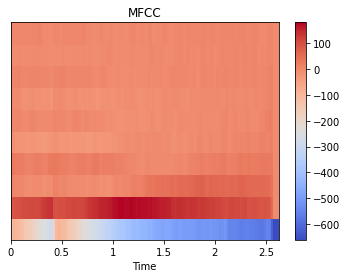

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mfcc_t, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

[Text(0.5, 1.0, 'MFCC')]

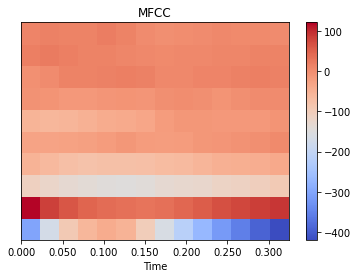

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mfcc_t2, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [ ]:
pp = '/content/drive/MyDrive/machine learning/melspectrogram_train/102305-6-0-0.png'
tt = img_to_array(load_img(pp,target_size=(64, 64)))

In [ ]:
rgb_weights = [0.2989, 0.5870, 0.1140]
image_grey = np.dot(tt, rgb_weights)

In [ ]:
image_grey.shape

(64, 64)

In [ ]:
S = librosa.feature.melspectrogram(y=sound, sr=sr, n_mels=128)
S2 = librosa.feature.melspectrogram(y=sound2, sr=sr2, n_mels=128)

In [ ]:
S_dB = librosa.power_to_db(S, ref=np.max)

In [ ]:
S_dB.shape

(128, 113)

In [ ]:
S_dB2 = librosa.power_to_db(S2, ref=np.max)

In [ ]:
S.shape

(128, 113)

In [ ]:
sacts.shape

(16, 113)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

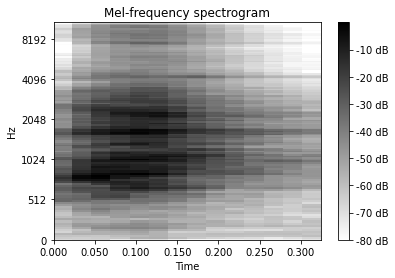

In [ ]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S2, ref=np.max)
img = librosa.display.specshow(S_dB,cmap='gray_r', x_axis='time',
                         y_axis='mel', sr=sr, ax=ax)
plt.colorbar(img, ax=ax, format='%+2.0f dB')
plt.set_cmap("gray")
ax.set(title='Mel-frequency spectrogram')

In [ ]:
S_dB.shape

(128, 14)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

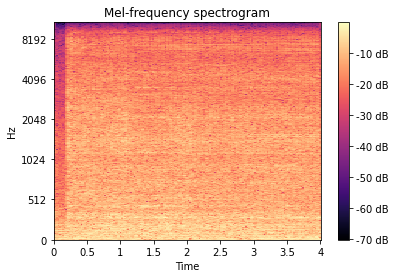

In [ ]:
fig, ax = plt.subplots()
S_dB2 = librosa.power_to_db(S2, ref=np.max)
img2 = librosa.display.specshow(S_dB2, x_axis='time',
                         y_axis='mel', sr=sr2, ax=ax)
fig.colorbar(img2, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
S2 = np.abs(librosa.stft(sound))

In [ ]:
S2.shape

(1025, 173)

In [ ]:
comps2, acts2 = librosa.decompose.decompose(S, n_components=5)
S_approx2 = comps2.dot(acts2)

In [ ]:
comps3, acts3 = librosa.decompose.decompose(S, n_components=200)
S_approx3 = comps3.dot(acts3)

In [ ]:
comps3.shape

(128, 16)

[Text(0.5, 1.0, 'reconstruct')]

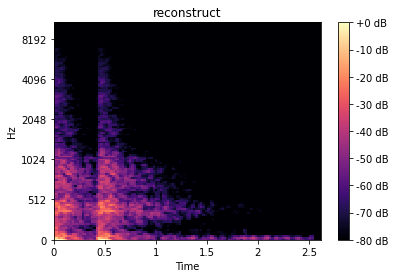

In [ ]:
fig, ax = plt.subplots()
S_dB = librosa.amplitude_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='reconstruct')

[Text(0.5, 1.0, 'reconstruct')]

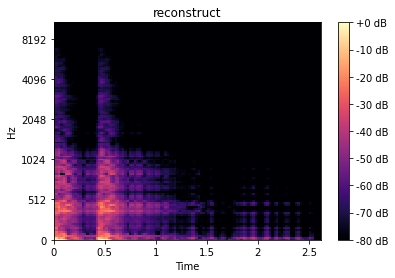

In [ ]:
fig, ax = plt.subplots()
S_dB = librosa.amplitude_to_db(S_approx2, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='reconstruct')

[Text(0.5, 1.0, 'reconstruct')]

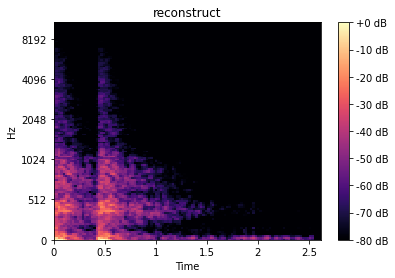

In [ ]:
fig, ax = plt.subplots()
S_dB = librosa.amplitude_to_db(S_approx3, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='reconstruct')

In [ ]:
Counter(meta['classID'])

Counter({0: 1000,
         1: 429,
         2: 1000,
         3: 1000,
         4: 1000,
         5: 1000,
         6: 374,
         7: 1000,
         8: 929,
         9: 1000})

## 1.4 Feature Extraction

In [7]:
def mel_data(raw_data):
  mel_fre = []
  for i in range(len(raw_data)):
    signal = raw_data[i]
    S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max).T
    f = S_dB.flatten()
    mel_fre.append(f)
  mel_fre = np.asarray(mel_fre).reshape(len(raw_data),41,128)
  return mel_fre

In [13]:
def mfcc_data(raw_data):
  mfcc = []
  for i in range(len(raw_data)): 
    signal = raw_data[i] 
    S = librosa.feature.mfcc(y=signal, n_mfcc=50)
    S_dB = librosa.power_to_db(S, ref=np.max).T
    f = S_dB.flatten()
    mfcc.append(f)
  mfcc = np.asarray(mfcc).reshape(len(raw_data),41,50) 
  return mfcc

In [14]:
def chroma_data(raw_data):
  chroma_d = []
  for i in range(len(raw_data)):
    signal = raw_data[i]
    chroma = librosa.feature.chroma_stft(y=signal).T
    f = chroma.flatten()
    chroma_d.append(f)
  chroma_d = np.asarray(chroma_d).reshape(len(raw_data),41,12) 
  return chroma_d

In [8]:
mel_train_data = mel_data(train_raw_split)
mel_valid_data = mel_data(valid_raw_split)

In [16]:
mfcc_train_data = mfcc_data(train_raw_split)
mfcc_valid_data = mfcc_data(valid_raw_split)

In [ ]:
mel_test_data = mel_data(test_raw_split)
mfcc_test_data = mfcc_data(test_raw_split)

In [17]:
chroma_train_data = chroma_data(train_raw_split)
chroma_valid_data = chroma_data(valid_raw_split)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
chroma_test_data = chroma_data(test_raw_split)

In [18]:
all_feature_train = np.concatenate((mel_train_data, mfcc_train_data, chroma_train_data), axis = 2)

In [19]:
np.save('/content/drive/MyDrive/machine learning/all_feature_train.npy', all_feature_train)

In [20]:
all_feature_valid = np.concatenate((mel_valid_data, mfcc_valid_data, chroma_valid_data), axis = 2)

In [21]:
np.save('/content/drive/MyDrive/machine learning/all_feature_valid.npy', all_feature_valid)

In [ ]:
all_feature_test = np.concatenate((mel_test_data, mfcc_test_data, chroma_test_data), axis = 2)

In [ ]:
np.save('/content/drive/MyDrive/machine learning/all_feature_test.npy', all_feature_test)

## 1.5 Image Generation

In [ ]:
# load Image function
def load_image(meta_data, save_path):
  image_array = []

  for i in range(len(meta_data)):
    p = save_path + meta_data['name'][i] + '-' + str(i) + '.png'
    p = pathlib.Path(p)
    a = img_to_array(load_img(p, target_size=(32, 32)))
    image_array.append(a)
  return np.array(image_array)

### 1.4.1 Mel-frequency Spectrogram

In [37]:
pathlib.Path(f'/content/drive/MyDrive/machine learning/melspectrogram_train').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/melspectrogram_valid').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/melspectrogram_test').mkdir(parents=True, exist_ok=True)

In [38]:
mel_train_path = '/content/drive/MyDrive/machine learning/melspectrogram_train/'
mel_valid_path = '/content/drive/MyDrive/machine learning/melspectrogram_valid/'
mel_test_path = '/content/drive/MyDrive/machine learning/melspectrogram_test/'

In [39]:
def mel_spect(raw_data, meta, fold_name, save_path):
  for i in list(meta[meta['fold']==fold_name].index):
    signal = raw_data[i]
    S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
    plt.axis('off')
    name = save_path + meta['name'][i] + '-' + str(i)
    plt.savefig('{}.png'.format(name), bbox_inches='tight', pad_inches=0.0)
    plt.clf()
    plt.close()

In [ ]:
mel_spect(test_raw_split, test_meta_split, 'fold7', mel_test_path)  

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/melspectrogram_valid.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/melspectrogram_train.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/melspectrogram_test.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
mel_train_img = '/content/melspectrogram_train/'
mel_train_array = load_image(train_meta_split, mel_train_img)  

In [ ]:
mel_valid_img = '/content/melspectrogram_valid/'
mel_valid_array = load_image(valid_meta_split, mel_valid_img)  

In [ ]:
mel_test_img = '/content/melspectrogram_test/'
mel_test_array = load_image(test_meta_split, mel_test_img)  

In [ ]:
np.save('/content/drive/MyDrive/machine learning/mel_train_array.npy', mel_train_array)
np.save('/content/drive/MyDrive/machine learning/mel_test_array.npy', mel_test_array) 
np.save('/content/drive/MyDrive/machine learning/mel_valid_array.npy', mel_valid_array) 

### 1.4.2 MFCCs Plot

In [ ]:
pathlib.Path(f'/content/drive/MyDrive/machine learning/mfcc_plot_train').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/mfcc_plot_valid').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/mfcc_plot_test').mkdir(parents=True, exist_ok=True)

In [ ]:
mfcc_train_path = '/content/drive/MyDrive/machine learning/mfcc_plot_train/'
mfcc_valid_path = '/content/drive/MyDrive/machine learning/mfcc_plot_valid/'
mfcc_test_path = '/content/drive/MyDrive/machine learning/mfcc_plot_test/'

In [ ]:
def mfcc_plot(raw_data, meta, fold_name, save_path):
  for i in list(meta[meta['fold']==fold_name].index):
    signal = raw_data[i]   
    S = librosa.feature.mfcc(y=signal, n_mfcc=50)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
    plt.axis('off')
    name = save_path + meta['name'][i] + '-' + str(i)
    plt.savefig('{}.png'.format(name), bbox_inches='tight', pad_inches=0.0)
    plt.clf()
    plt.close()

In [ ]:
mfcc_plot(train_raw_split, train_meta_split, 'fold1', mfcc_train_path)

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/mfcc_plot_valid.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/mfcc_plot_train.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/mfcc_plot_test.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
mfcc_train_img = '/content/mfcc_plot_train/'
mfcc_train_array = load_image(train_meta_split, mfcc_train_img)

In [ ]:
mfcc_valid_img = '/content/mfcc_plot_valid/'
mfcc_valid_array = load_image(valid_meta_split, mfcc_valid_img)

In [ ]:
mfcc_test_img = '/content/mfcc_plot_test/'
mfcc_test_array = load_image(test_meta_split, mfcc_test_img)

In [ ]:
np.save('/content/drive/MyDrive/machine learning/mfcc_train_array.npy', mfcc_train_array)
np.save('/content/drive/MyDrive/machine learning/mfcc_test_array.npy', mfcc_test_array)
np.save('/content/drive/MyDrive/machine learning/mfcc_valid_array.npy', mfcc_valid_array)

### 1.4.3 Chromagram

In [41]:
pathlib.Path(f'/content/drive/MyDrive/machine learning/chromagram_train').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/chromagram_test').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/chromagram_valid').mkdir(parents=True, exist_ok=True)

In [42]:
chroma_train_path = '/content/drive/MyDrive/machine learning/chromagram_train/'
chroma_valid_path = '/content/drive/MyDrive/machine learning/chromagram_valid/'
chroma_test_path = '/content/drive/MyDrive/machine learning/chromagram_test/'

In [43]:
def chromagram_plot(raw_data, meta, fold_name, save_path):
  for i in list(meta[meta['fold']==fold_name].index):
    signal = raw_data[i]
    chroma = librosa.feature.chroma_stft(y=signal)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(chroma, ax= ax)
    plt.axis('off')
    name = save_path + meta['name'][i] + '-' + str(i)
    plt.savefig('{}.png'.format(name), bbox_inches='tight', pad_inches=0.0)       
    plt.clf()
    plt.close()

In [ ]:
chromagram_plot(train_raw_split, train_meta_split, 'fold1', chroma_train_path) 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/chromagram_valid.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/chromagram_train.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/chromagram_test.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
chroma_train_img = '/content/chromagram_train/'
chroma_train_array = load_image(train_meta_split, chroma_train_img) 

In [ ]:
chroma_valid_img = '/content/chromagram_valid/'
chroma_valid_array = load_image(valid_meta_split, chroma_valid_img) 

In [ ]:
chroma_test_img = '/content/chromagram_test/'
chroma_test_array = load_image(test_meta_split, chroma_test_img) 

In [ ]:
chroma_train_array.shape 

In [ ]:
np.save('/content/drive/MyDrive/machine learning/chroma_train_array.npy', chroma_train_array) 

In [ ]:
np.save('/content/drive/MyDrive/machine learning/chroma_test_array.npy', chroma_test_array) 

In [ ]:
np.save('/content/drive/MyDrive/machine learning/chroma_valid_array.npy', chroma_valid_array) 

### 1.4.4 Combined Image

In [ ]:
mel_train_array = np.load('/content/drive/MyDrive/machine learning/mel_train_array.npy')
mel_test_array = np.load('/content/drive/MyDrive/machine learning/mel_test_array.npy')
mel_valid_array = np.load('/content/drive/MyDrive/machine learning/mel_valid_array.npy')

In [ ]:
mfcc_train_array = np.load('/content/drive/MyDrive/machine learning/mfcc_train_array.npy')
mfcc_test_array = np.load('/content/drive/MyDrive/machine learning/mfcc_test_array.npy')
mfcc_valid_array = np.load('/content/drive/MyDrive/machine learning/mfcc_valid_array.npy')

In [ ]:
chroma_train_array = np.load('/content/drive/MyDrive/machine learning/chroma_train_array.npy')
chroma_test_array = np.load('/content/drive/MyDrive/machine learning/chroma_test_array.npy')
chroma_valid_array = np.load('/content/drive/MyDrive/machine learning/chroma_valid_array.npy')

In [ ]:
def img_combine(mel_array, mfcc_array, chroma_array):
  array_new = np.concatenate((mel_array[:,:,:,0][:,:,:,np.newaxis], mfcc_array[:,:,:,1][:,:,:,np.newaxis],chroma_array[:,:,:,2][:,:,:,np.newaxis]), axis =3)
  return array_new

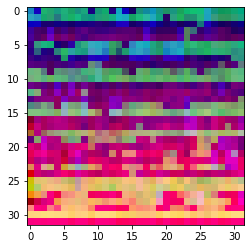

In [ ]:
plt.imshow(train_com[0].astype('float32')/255)

# 2 Feed-Forward Neural Network

## 2.1 FFN neural network with mel-frequency spectrogram

In [ ]:
rgb_weights = [0.2989, 0.5870, 0.1140]
def grey_flat(a):
  grey_array = np.ndarray(shape=(a.shape[0], 32, 32))
  for i in range(a.shape[0]):
    image_convert = a[i]
    grey_array[i] = np.dot(image_convert[...,:3], rgb_weights)
  flat_array = np.ndarray(shape=(1024, grey_array.shape[0]))
  for i in range(grey_array.shape[0]):
    flat_array[:,i] = np.concatenate(grey_array[i])
  return flat_array

In [ ]:
X_train_grey = grey_flat(X_train_array).T
X_valid_grey = grey_flat(X_valid_array).T
X_test_grey = grey_flat(X_test_array).T

In [ ]:
standard_scaler = preprocessing.StandardScaler()
X_train_flat_T = standard_scaler.fit_transform(X_train_grey)
X_valid_flat_T = standard_scaler.transform(X_valid_grey)
X_test_flat_T = standard_scaler.transform(X_test_grey)

In [ ]:
X_train_flat_T,y_train = shuffle(X_train_flat_T, y_train)
X_valid_flat_T,y_valid = shuffle(X_valid_flat_T, y_valid)

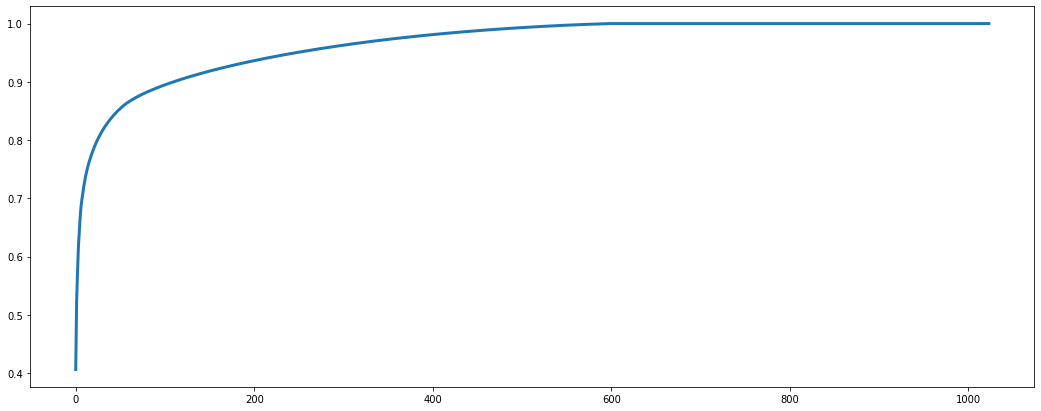

In [ ]:
pca = PCA().fit(X_train_flat_T)
plt.figure(figsize=(18, 7))
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [ ]:
def PCA_iter(x_all,start, end, step):
  lis =[]
  for i in range(start, end, step):
    (train, valid, test) = x_all
    pca = PCA(n_components=i)

    pca.fit_transform(train)
                
    train_PCA =  pca.transform(train)
    train_new = pca.inverse_transform(train_PCA)

    valid_PCA =  pca.transform(valid)       
    valid_new = pca.inverse_transform(valid_PCA)
                
    test_PCA = pca.transform(test)
    test_new = pca.inverse_transform(test_PCA)

    tupla = (x_train_PCA, x_valid_PCA, x_test_PCA) =train_new,valid_new,test_new
                
    lis.append(tupla)
  
  return lis

In [ ]:
lis_PCA =  PCA_iter((X_train_flat_T,X_valid_flat_T, X_test_flat_T),10,201,20)

In [ ]:
lis_PCA.append((X_train_flat_T,X_valid_flat_T, X_test_flat_T))

In [ ]:
def FW_iter(lis_PCA, ep, bs):
    lis_FW = []
    epochs = ep
    batch_size = bs
    for itr in range(len(lis_PCA)):
        x_train_PCA, x_valid_PCA, x_test_PCA = lis_PCA[itr]
        
       
        print("FW- components: ",(itr+1)*20-10)
        #feed forward neural network
        model = tf.keras.Sequential([
          tf.keras.layers.Input(shape = (1024)),
          tf.keras.layers.Dense(64, activation = "relu"),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Dense(10, activation='softmax')
          ])
        model.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])
        
        
        history = model.fit(x_train_PCA, y_train,
                        batch_size = bs,
                        epochs = epochs,
                        validation_data=(x_valid_PCA, y_valid))
        
        y_pred = model.predict(x_test_PCA).round()
        
        tupla = (history, model)
        lis_FW.append(tupla)
    return lis_FW

In [ ]:
epochs = 10
batch_size = 16
res = FW_iter(lis_PCA, epochs, batch_size)

FW- components:  10
Epoch 1/10
227/227 [==============================] - 1s 3ms/step - loss: 1.8107 - accuracy: 0.3533 - val_loss: 1.8310 - val_accuracy: 0.3608
Epoch 2/10
227/227 [==============================] - 1s 3ms/step - loss: 1.6152 - accuracy: 0.4385 - val_loss: 1.7967 - val_accuracy: 0.4479
Epoch 3/10
227/227 [==============================] - 1s 3ms/step - loss: 1.5343 - accuracy: 0.4407 - val_loss: 2.0239 - val_accuracy: 0.4215
Epoch 4/10
227/227 [==============================] - 1s 3ms/step - loss: 1.4894 - accuracy: 0.4644 - val_loss: 2.0382 - val_accuracy: 0.4422
Epoch 5/10
227/227 [==============================] - 1s 3ms/step - loss: 1.4425 - accuracy: 0.4876 - val_loss: 2.0170 - val_accuracy: 0.4605
Epoch 6/10
227/227 [==============================] - 1s 3ms/step - loss: 1.4267 - accuracy: 0.4961 - val_loss: 1.9855 - val_accuracy: 0.4238
Epoch 7/10
227/227 [==============================] - 1s 3ms/step - loss: 1.4219 - accuracy: 0.5019 - val_loss: 2.0112 - val_acc

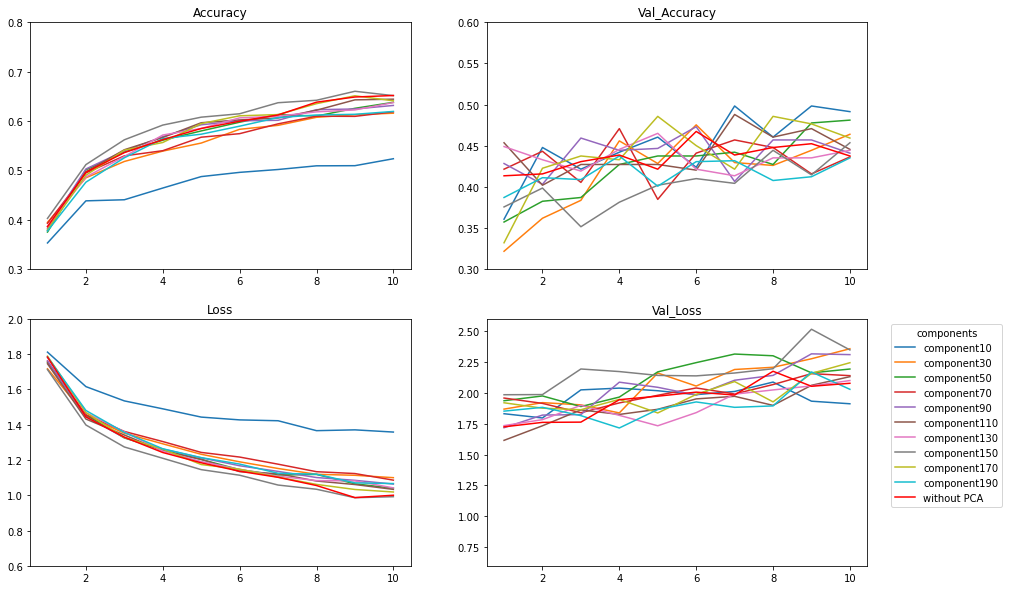

In [ ]:
fontP = FontProperties()
fontP.set_size('medium')

fig, ax = plt.subplots(2,2,figsize=(15,10))

x = list(range(1,11))

for i in range(10):
  accuracy = res[i][0].history['accuracy']
  val_accuracy = res[i][0].history['val_accuracy']
  loss = res[i][0].history['loss']
  val_loss = res[i][0].history['val_loss']
  
  ax[0, 0].plot(x, accuracy, label = 'component' + str(i*20+10))
  ax[0, 1].plot(x, val_accuracy, label = 'component' + str(i*20+10))
  ax[1, 0].plot(x, loss, label = 'component' + str(i*20+10))
  ax[1, 1].plot(x, val_loss, label = 'component' + str(i*20+10))
ax[0, 0].plot(x, res[10][0].history['accuracy'], label = 'without PCA', color = 'red')
ax[0, 0].set(title='Accuracy')
ax[0, 0].set_ylim([0.3, 0.8])
ax[0, 1].plot(x, res[10][0].history['val_accuracy'], label = 'without PCA', color = 'red')
ax[0, 1].set(title='Val_Accuracy') 
ax[0, 1].set_ylim([0.3, 0.6])
ax[1, 0].plot(x, res[10][0].history['loss'], label = 'without PCA', color = 'red')
ax[1, 0].set(title='Loss')
ax[1, 0].set_ylim([0.6, 2])
ax[1, 1].plot(x, res[10][0].history['val_loss'], label = 'without PCA', color = 'red')
ax[1, 1].set(title='Val_Loss')
ax[1, 1].set_ylim([0.6, 2.6])

plt.legend(title='components', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)


# 3 Convolution Neural Network

## 3.1 Image Classification

### 3.1.1 Image of Mel-Frequency Spectrogram

In [ ]:
X_train = mel_train_array.astype('float32')/255 
X_valid = mel_valid_array.astype('float32')/255
X_test = mel_test_array.astype('float32')/255

In [ ]:
y_train_label = train_meta_split['label']
y_valid_label = valid_meta_split['label']
y_test_label = test_meta_split['label']

In [ ]:
y_train = np_utils.to_categorical(y_train_label,10)
y_valid = np_utils.to_categorical(y_valid_label,10)
y_test = np_utils.to_categorical(y_test_label,10)

In [ ]:
X_train,y_train = shuffle(X_train,y_train) 
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape = (32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model_cnn.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])


model_cnn.summary()

In [ ]:
history_cnn = model_cnn.fit(X_train,y_train,
        batch_size = 16,
        epochs=10,
        validation_data=(X_valid, y_valid))

### 3.1.2 Image of Chromagram

In [ ]:
X_train = chroma_train_array.astype('float32')/255
X_valid = chroma_valid_array.astype('float32')/255
X_test = chroma_test_array.astype('float32')/255

In [ ]:
y_train_label = train_meta_split['label']
y_valid_label = valid_meta_split['label']
y_test_label = test_meta_split['label']

In [ ]:
y_train = np_utils.to_categorical(y_train_label,10)
y_valid = np_utils.to_categorical(y_valid_label,10)
y_test = np_utils.to_categorical(y_test_label,10)

In [ ]:
X_train,y_train = shuffle(X_train,y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
model_cnn_chroma = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape = (32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model_cnn_chroma.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])


model_cnn_chroma.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)         

In [ ]:
history_cnn = model_cnn_chroma.fit(X_train,y_train,
        batch_size = 16,
        epochs=10,
        validation_data=(X_valid, y_valid))

Epoch 1/10
1739/1739 [==============================] - 42s 6ms/step - loss: 1.8232 - accuracy: 0.3045 - val_loss: 1.6782 - val_accuracy: 0.3902
Epoch 2/10
1739/1739 [==============================] - 10s 6ms/step - loss: 1.4379 - accuracy: 0.4768 - val_loss: 1.4491 - val_accuracy: 0.4890
Epoch 3/10
1739/1739 [==============================] - 10s 6ms/step - loss: 1.2503 - accuracy: 0.5555 - val_loss: 1.5445 - val_accuracy: 0.4939
Epoch 4/10
1739/1739 [==============================] - 10s 6ms/step - loss: 1.1435 - accuracy: 0.5973 - val_loss: 1.6050 - val_accuracy: 0.4688
Epoch 5/10
1739/1739 [==============================] - 9s 5ms/step - loss: 1.0740 - accuracy: 0.6210 - val_loss: 1.5076 - val_accuracy: 0.4967
Epoch 6/10
1739/1739 [==============================] - 9s 5ms/step - loss: 1.0144 - accuracy: 0.6465 - val_loss: 1.6762 - val_accuracy: 0.4873
Epoch 7/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.9822 - accuracy: 0.6563 - val_loss: 1.5264 - val_accur

### 3.1.3 Image of MFCC plot

In [ ]:
X_train = mfcc_train_array.astype('float32')/255
X_valid = mfcc_valid_array.astype('float32')/255
X_test = mfcc_test_array.astype('float32')/255

In [ ]:
y_train_label = train_meta_split['label']
y_valid_label = valid_meta_split['label']
y_test_label = test_meta_split['label']

In [ ]:
y_train = np_utils.to_categorical(y_train_label,10)
y_valid = np_utils.to_categorical(y_valid_label,10)
y_test = np_utils.to_categorical(y_test_label,10)

In [ ]:
X_train,y_train = shuffle(X_train,y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
model_cnn_mfcc = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape = (32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model_cnn_mfcc.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])


model_cnn_mfcc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [ ]:
history_cnn = model_cnn_mfcc.fit(X_train,y_train,
        batch_size = 16,
        epochs=10,
        validation_data=(X_valid, y_valid))

Epoch 1/10
1739/1739 [==============================] - 41s 5ms/step - loss: 1.6367 - accuracy: 0.4017 - val_loss: 2.1457 - val_accuracy: 0.3498
Epoch 2/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.8613 - accuracy: 0.7100 - val_loss: 2.0430 - val_accuracy: 0.4203
Epoch 3/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.6497 - accuracy: 0.7794 - val_loss: 2.0857 - val_accuracy: 0.4096
Epoch 4/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.5496 - accuracy: 0.8167 - val_loss: 2.9560 - val_accuracy: 0.3795
Epoch 5/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.4952 - accuracy: 0.8322 - val_loss: 2.6993 - val_accuracy: 0.4004
Epoch 6/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.4429 - accuracy: 0.8496 - val_loss: 2.7901 - val_accuracy: 0.4213
Epoch 7/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.4110 - accuracy: 0.8615 - val_loss: 3.1739 - val_accuracy

### 3.1.4 Image Combination

In [ ]:
train_com = img_combine(mel_train_array, mfcc_train_array, chroma_train_array)
test_com = img_combine(mel_test_array, mfcc_test_array, chroma_test_array)
valid_com = img_combine(mel_valid_array, mfcc_valid_array, chroma_valid_array)

In [ ]:
X_train = train_com.astype('float32')/255
X_test = test_com.astype('float32')/255
X_valid = valid_com.astype('float32')/255

In [ ]:
y_train_label = train_meta_split['label']
y_valid_label = valid_meta_split['label']
y_test_label = test_meta_split['label']

In [ ]:
y_train = np_utils.to_categorical(y_train_label,10)
y_valid = np_utils.to_categorical(y_valid_label,10)
y_test = np_utils.to_categorical(y_test_label,10)

In [ ]:
X_train,y_train = shuffle(X_train,y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
model_cnn_com = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape = (32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.4),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model_cnn_com.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])


model_cnn_com.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)         

In [ ]:
history_cnn = model_cnn_com.fit(X_train,y_train,
        batch_size = 16,
        epochs=10,
        validation_data=(X_valid, y_valid))

Epoch 1/10
1739/1739 [==============================] - 11s 6ms/step - loss: 1.8517 - accuracy: 0.2994 - val_loss: 2.0059 - val_accuracy: 0.2916
Epoch 2/10
1739/1739 [==============================] - 11s 6ms/step - loss: 1.1918 - accuracy: 0.5852 - val_loss: 1.8360 - val_accuracy: 0.4199
Epoch 3/10
1739/1739 [==============================] - 10s 6ms/step - loss: 0.9016 - accuracy: 0.6959 - val_loss: 2.3933 - val_accuracy: 0.3816
Epoch 4/10
1739/1739 [==============================] - 10s 5ms/step - loss: 0.7520 - accuracy: 0.7440 - val_loss: 2.3101 - val_accuracy: 0.4597
Epoch 5/10
1739/1739 [==============================] - 10s 5ms/step - loss: 0.6757 - accuracy: 0.7723 - val_loss: 2.1461 - val_accuracy: 0.4581
Epoch 6/10
1739/1739 [==============================] - 10s 6ms/step - loss: 0.6307 - accuracy: 0.7870 - val_loss: 2.4227 - val_accuracy: 0.4426
Epoch 7/10
1739/1739 [==============================] - 10s 6ms/step - loss: 0.5861 - accuracy: 0.8067 - val_loss: 2.8093 - val_ac

## 3.2 Classification with Features

- Mel-frequency Spectrogram: 128
- Chromagram: 12
- Tonnetz: 6
- MFCCs: 50

In [ ]:
def extract_features(raw_data):
  all_feature = []
  for signal in raw_data:
    melspec = librosa.feature.melspectrogram(signal, n_mels = 128) # melspectrogram features
    logspec = librosa.amplitude_to_db(melspec)
    chroma = librosa.feature.chroma_stft(S=logspec) # chromagram features
    y = librosa.effects.harmonic(signal)
    tonnetz = librosa.feature.tonnetz(y=y) # tonnetz features
    mfcc = librosa.feature.mfcc(S=logspec, n_mfcc=50)
    f = np.concatenate((logspec, chroma, tonnetz, mfcc), axis=0)
    f = f.T.flatten()[:, np.newaxis].T
    all_feature.append(f)
           
  all_feature = np.asarray(all_feature).reshape(len(all_feature),196,41,1)
  features = np.concatenate((all_feature, np.zeros(np.shape(all_feature))), axis = 3)
  for i in range(len(features)):
    features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
  return np.array(features)

In [ ]:
feature_fold1 = extract_features(train_raw_split) 

In [ ]:
np.save('/content/drive/MyDrive/machine learning/all_feature_train.npy', feature_fold1') 

In [ ]:
all_feature_valid = extract_features(valid_raw_split) 

In [ ]:
np.save('/content/drive/MyDrive/machine learning/all_feature_valid.npy', all_feature_valid') 

In [ ]:
all_feature_test = extract_features(test_raw_split) 

In [ ]:
np.save('/content/drive/MyDrive/machine learning/all_feature_valid.npy', all_feature_valid') 

In [ ]:
X_train = all_feature_train
X_valid = all_feature_valid
X_test = all_feature_test 

In [ ]:
y_train = np_utils.to_categorical(train_label,10)
y_valid = np_utils.to_categorical(valid_label,10)
y_test = np_utils.to_categorical(test_label,10) 

In [ ]:
model_cnn_s = Sequential([
     Conv2D(32,kernel_size=1,strides=1, padding='same', input_shape=(196, 41, 2)),
     Conv2D(32,kernel_size=1,strides=1, padding='same',activation='relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.5),

     Conv2D(64,kernel_size=1,strides=1, padding='same', input_shape=(128, 41, 2)),
     Conv2D(64,kernel_size=1,strides=1, padding='same',activation='relu'),
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.5),    

     Flatten(),

     Dense(128,activation='relu'),
     Dropout(0.5),

     Dense(10,activation='softmax')
])
     
model_cnn_s.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn_s.summary()

In [ ]:
history_cnn_s = model_cnn_s.fit(X_train, y_train, batch_size=16, epochs=15, validation_data=(X_valid, y_valid)) 

# 4 Convolution Recurrent Neural Network

## 4.1 CRNN with Mel-Frequency Spectrogram

In [28]:
mel_valid_data = mel_data(valid_raw_split)

In [29]:
mel_train_data = mel_data(train_raw_split)

In [30]:
train_label = train_meta_split['label']
valid_label = valid_meta_split['label']

In [31]:
y_train = np_utils.to_categorical(train_label,10)
y_valid = np_utils.to_categorical(valid_label,10)

In [33]:
X_train = mel_train_data
X_valid = mel_valid_data

In [34]:
X_train,y_train = shuffle(X_train,y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [23]:
model_crnn = Sequential([
    Conv1D(16, 1, activation='relu', input_shape = (41,128)),
    MaxPooling1D(2),
    Dropout(0.1),

    Conv1D(32, 1, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.1),

    Conv1D(64, 1, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.1),    
  

    LSTM(96, return_sequences=False),
    Dropout(0.4),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation = 'softmax')
])


optimizer = adam_v2.Adam(learning_rate=0.001)
model_crnn.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model_crnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 41, 16)            2064      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 20, 16)            0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 20, 16)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 20, 32)            544       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 10, 32)            0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 10, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 10, 64)           

In [ ]:
history = model_crnn.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_valid, y_valid))

## 4.2 With all features

In [23]:
X_train = all_feature_train
X_valid = all_feature_valid

In [24]:
y_train = np_utils.to_categorical(train_meta_split['label'],10)
y_valid = np_utils.to_categorical(valid_meta_split['label'],10)

In [25]:
X_train,y_train = shuffle(X_train,y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [31]:
model_crnn_all = Sequential([
    Conv1D(16, 1, activation='relu', input_shape = (41,190)),
    MaxPooling1D(2),
    Dropout(0.1),

    Conv1D(32, 1, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.1),

    Conv1D(64, 1, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.1),    
  

    LSTM(96, return_sequences=False),
    Dropout(0.4),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation = 'softmax')
])


optimizer = adam_v2.Adam(learning_rate=0.001)
model_crnn_all.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model_crnn_all.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 41, 16)            3056      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 16)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 16)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 20, 32)            544       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 10, 64)           

In [32]:
history = model_crnn_all.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid)) 

Epoch 1/50
870/870 [==============================] - 11s 9ms/step - loss: 2.0065 - accuracy: 0.2525 - val_loss: 2.1180 - val_accuracy: 0.1997
Epoch 2/50
870/870 [==============================] - 7s 8ms/step - loss: 1.6937 - accuracy: 0.3936 - val_loss: 2.1364 - val_accuracy: 0.2558
Epoch 3/50
870/870 [==============================] - 7s 8ms/step - loss: 1.4781 - accuracy: 0.4865 - val_loss: 1.9918 - val_accuracy: 0.3148
Epoch 4/50
870/870 [==============================] - 7s 8ms/step - loss: 1.2741 - accuracy: 0.5737 - val_loss: 2.0419 - val_accuracy: 0.3844
Epoch 5/50
870/870 [==============================] - 7s 9ms/step - loss: 1.1495 - accuracy: 0.6166 - val_loss: 2.1734 - val_accuracy: 0.3950
Epoch 6/50
870/870 [==============================] - 7s 8ms/step - loss: 1.0525 - accuracy: 0.6537 - val_loss: 2.3082 - val_accuracy: 0.3930
Epoch 7/50
870/870 [==============================] - 7s 9ms/step - loss: 0.9933 - accuracy: 0.6739 - val_loss: 2.2965 - val_accuracy: 0.4073
Epoch

KeyboardInterrupt: ignored

# 5 Parallel CNN-RNN Model

## 5.1 with Mel-Frequency Spectrogram

In [59]:
def parallel_cnn_rnn(model_input):
  print('Builing model...')
  layer = model_input

  ## CNN block
  conv_1 = Conv2D(16, (3, 1), strides=1, padding = 'same', activation='relu')(layer)
  pool_1 = MaxPooling2D((2,2))(conv_1)

  conv_2 = Conv2D(32, (3, 1), strides=1, padding = 'same', activation='relu')(pool_1)
  pool_2 = MaxPooling2D((2,2))(conv_2)

  conv_3 = Conv2D(64, (3, 1), strides=1, padding = 'same', activation='relu')(pool_2)
  pool_3 = MaxPooling2D((2,2))(conv_3)

  conv_4 = Conv2D(64, (3, 1), strides=1, padding = 'same', activation='relu')(pool_3)
  pool_4 = MaxPooling2D((2,2))(conv_4)

  conv_5 = Conv2D(64, (3, 1), strides=1, padding = 'same', activation='relu')(pool_4)
  pool_5 = MaxPooling2D((2,2))(conv_5)

  flatten_1 = Flatten()(pool_5)

  ## Bi-RNN block
  pool_lstm1 = MaxPooling2D((4,2))(layer)
  squeezed = Lambda(lambda x: keras.backend.squeeze(x, axis= -1))(pool_lstm1)
  lstm = Bidirectional(GRU(64))(squeezed)

  ## Concat two output
  concat = concatenate([flatten_1, lstm], axis=-1)
  output = Dense(10, activation = 'softmax')(concat)

  model_output = output

  model = Model(model_input, model_output)

  optimizer = adam_v2.Adam(learning_rate=0.001)
  model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  print(model.summary())
  
  return model

In [60]:
model_input = Input((41,128,1))
model_pcrnn = parallel_cnn_rnn(model_input)

Builing model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 41, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 41, 128, 16)  64          input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 20, 64, 16)   0           conv2d_52[0][0]                  
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 20, 64, 32)   1568        max_pooling2d_48[0][0]           
___________________________________________________________________________

In [61]:
X_train = mel_train_data
X_valid = mel_valid_data

In [62]:
y_train = np_utils.to_categorical(train_meta_split['label'], 10)
y_valid = np_utils.to_categorical(valid_meta_split['label'], 10)

In [63]:
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [64]:
X_train.shape

(27809, 41, 128)

In [65]:
X_train_new = X_train[:,:,:, np.newaxis]
X_valid_new = X_valid[:,:,:, np.newaxis]

In [67]:
history = model_pcrnn.fit(X_train_new, y_train, batch_size=16, epochs=20, validation_data=(X_valid_new, y_valid))

Epoch 1/20
1739/1739 [==============================] - 15s 8ms/step - loss: 1.4123 - accuracy: 0.5054 - val_loss: 1.5817 - val_accuracy: 0.4746
Epoch 2/20
1739/1739 [==============================] - 13s 8ms/step - loss: 1.0647 - accuracy: 0.6281 - val_loss: 1.4374 - val_accuracy: 0.5219
Epoch 3/20
1739/1739 [==============================] - 13s 8ms/step - loss: 0.9034 - accuracy: 0.6896 - val_loss: 1.4349 - val_accuracy: 0.5410
Epoch 4/20
1739/1739 [==============================] - 13s 8ms/step - loss: 0.7966 - accuracy: 0.7339 - val_loss: 1.4858 - val_accuracy: 0.5481
Epoch 5/20
1739/1739 [==============================] - 13s 8ms/step - loss: 0.7023 - accuracy: 0.7643 - val_loss: 1.4322 - val_accuracy: 0.5409
Epoch 6/20
1739/1739 [==============================] - 13s 8ms/step - loss: 0.6511 - accuracy: 0.7828 - val_loss: 1.3742 - val_accuracy: 0.5968
Epoch 7/20
1739/1739 [==============================] - 13s 8ms/step - loss: 0.5923 - accuracy: 0.8033 - val_loss: 1.4562 - val_ac

# 6 Error Analysis